In [1]:
!pip install pycountry


In [2]:
import pandas as pd
import requests

# API URLs
urls = {

    "adult_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_30C",
    "child_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C",
    "adult_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_18C",
    "child_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"
}

def fetch_data(url):
    response = requests.get(url)
    return pd.json_normalize(response.json()['value'])

df_adult_obesity = fetch_data(urls["adult_obesity"])
df_child_obesity = fetch_data(urls["child_obesity"])
df_adult_malnutrition = fetch_data(urls["adult_malnutrition"])
df_child_malnutrition = fetch_data(urls["child_malnutrition"])


In [3]:
df_adult_obesity

,Id,IndicatorCode,SpatialDimType,SpatialDim,TimeDimType,ParentLocationCode,ParentLocation,Dim1Type,TimeDim,Dim1,...,DataSourceDim,Value,NumericValue,Low,High,Comments,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd
0,5540695,NCD_BMI_30C,COUNTRY,MDA,YEAR,EUR,Europe,SEX,2018,SEX_BTSX,...,None,25.9 [23.9-28.0],25.94346,23.92528,28.04794,None,2024-02-29T16:06:41.017+01:00,2018,2018-01-01T00:00:00+01:00,2018-12-31T00:00:00+01:00
1,5541156,NCD_BMI_30C,COUNTRY,IRL,YEAR,EUR,Europe,SEX,1995,SEX_MLE,...,None,16.3 [13.6-19.2],16.26016,13.62936,19.19998,None,2024-02-29T16:06:41.017+01:00,1995,1995-01-01T00:00:00+01:00,1995-12-31T00:00:00+01:00
2,5541485,NCD_BMI_30C,COUNTRY,TUR,YEAR,EUR,Europe,SEX,1999,SEX_BTSX,...,None,21.3 [20.5-22.2],21.30304,20.48522,22.18512,None,2024-02-29T16:06:41.017+01:00,1999,1999-01-01T00:00:00+01:00,1999-12-31T00:00:00+01:00
3,5541635,NCD_BMI_30C,COUNTRY,ZAF,YEAR,AFR,Africa,SEX,1995,SEX_MLE,...,None,6.7 [5.5-8.0],6.68046,5.49292,7.99104,None,2024-02-29T16:06:41.017+01:00,1995,1995-01-01T00:00:00+01:00,1995-12-31T00:00:00+01:00
4,257,NCD_BMI_30C,COUNTRY,KHM,YEAR,WPR,Western Pacific,SEX,2001,SEX_BTSX,...,None,1.0 [0.8-1.3],0.98170,0.75674,1.27487,None,2024-02-29T16:06:41.017+01:00,2001,2001-01-01T00:00:00+01:00,2001-12-31T00:00:00+01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20785,9762127,NCD_BMI_30C,COUNTRY,LTU,YEAR,EUR,Europe,SEX,2013,SEX_BTSX,...,None,27.4 [24.0-30.9],27.39776,24.04407,30.89829,None,2024-02-29T16:06:41.017+01:00,2013,2013-01-01T00:00:00+01:00,2013-12-31T00:00:00+01:00
20786,9762808,NCD_BMI_30C,COUNTRY,ARM,YEAR,EUR,Europe,SEX,1997,SEX_BTSX,...,None,14.0 [12.1-15.9],13.95061,12.09827,15.93363,None,2024-02-29T16:06:41.017+01:00,1997,1997-01-01T00:00:00+01:00,1997-12-31T00:00:00+01:00
20787,9764145,NCD_BMI_30C,COUNTRY,ERI,YEAR,AFR,Africa,SEX,2011,SEX_MLE,...,None,1.2 [0.8-1.8],1.20233,0.76718,1.78496,None,2024-02-29T16:06:41.017+01:00,2011,2011-01-01T00:00:00+01:00,2011-12-31T00:00:00+01:00
20788,9764252,NCD_BMI_30C,COUNTRY,VCT,YEAR,AMR,Americas,SEX,2003,SEX_MLE,...,None,10.2 [7.1-14.0],10.20733,7.09326,13.98207,None,2024-02-29T16:06:41.017+01:00,2003,2003-01-01T00:00:00+01:00,2003-12-31T00:00:00+01:00


In [4]:
def standardize(df, age_group):
    df = df[['ParentLocation', 'Dim1', 'TimeDim', 'Low', 'High', 'NumericValue', 'SpatialDim']].copy()
    df.columns = ['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate', 'Country']
    
    # Add new columns using .loc
    df.loc[:, 'Age_Group'] = age_group
    df.loc[:, 'CI_Width'] = df['UpperBound'] - df['LowerBound']
    
    # Convert country codes
    import pycountry
    def get_country(code):
        try:
            return pycountry.countries.get(alpha_3=code).name
        except:
            return special_cases.get(code, code)

    special_cases = {
        'GLOBAL': 'Global', 'AFR': 'Africa', 'EUR': 'Europe',
        'SEAR': 'South-East Asia Region', 'WPR': 'Western Pacific Region',
        'AMR': 'Americas Region', 'EMR': 'Eastern Mediterranean Region',
        'WB_LMI': 'Low & Middle Income', 'WB_UMI': 'Upper Middle Income',
        'WB_LI': 'Low Income', 'WB_HI': 'High Income'
    }

    df.loc[:, 'Country'] = df['Country'].apply(get_country)
    df.loc[:, 'Gender'] = df['Gender'].replace({'BTSX': 'Both', 'MLE': 'Male', 'FMLE': 'Female'})
    return df
df_obesity = pd.concat([
    standardize(df_adult_obesity, "Adult"),
    standardize(df_child_obesity, "Child/Adolescent")
], ignore_index=True)
df_malnutrition = pd.concat([
    standardize(df_adult_malnutrition, "Adult"),
    standardize(df_child_malnutrition, "Child/Adolescent")
], ignore_index=True)

# Apply using .loc as well to avoid warnings
df_obesity.loc[:, 'Obesity_Level'] = pd.cut(df_obesity['Mean_Estimate'], bins=[0, 25, 29.9, float('inf')], labels=["Low", "Moderate", "High"])
df_malnutrition.loc[:, 'Malnutrition_Level'] = pd.cut(df_malnutrition['Mean_Estimate'], bins=[0, 10, 19.9, float('inf')], labels=["Low", "Moderate", "High"])


In [5]:
print("Obesity dataset shape:", df_obesity.shape)
print("Malnutrition dataset shape:", df_malnutrition.shape)
print("Obesity dataset info:")
print(df_obesity.info())
print("Malnutrition dataset info:")
print(df_malnutrition.info())


Obesity dataset shape: (83160, 10)
Malnutrition dataset shape: (83160, 10)
Obesity dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83160 entries, 0 to 83159
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Region         78804 non-null  object  
 1   Gender         83160 non-null  object  
 2   Year           83160 non-null  int64   
 3   LowerBound     83160 non-null  float64 
 4   UpperBound     83160 non-null  float64 
 5   Mean_Estimate  83160 non-null  float64 
 6   Country        83160 non-null  object  
 7   Age_Group      83160 non-null  object  
 8   CI_Width       83160 non-null  float64 
 9   Obesity_Level  83160 non-null  category
dtypes: category(1), float64(4), int64(1), object(4)
memory usage: 5.8+ MB
None
Malnutrition dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83160 entries, 0 to 83159
Data columns (total 10 columns):
 #   Column              Non-Null Coun

In [6]:
print("\nMissing values in Obesity dataset:")
print(df_obesity.isnull().sum())

print("\nMissing values in Malnutrition dataset:")
print(df_malnutrition.isnull().sum())



Missing values in Obesity dataset:
Region           4356
Gender              0
Year                0
LowerBound          0
UpperBound          0
Mean_Estimate       0
Country             0
Age_Group           0
CI_Width            0
Obesity_Level       0
dtype: int64

Missing values in Malnutrition dataset:
Region                4356
Gender                   0
Year                     0
LowerBound               0
UpperBound               0
Mean_Estimate            0
Country                  0
Age_Group                0
CI_Width                 0
Malnutrition_Level       0
dtype: int64


In [7]:
df_obesity['Region'] = df_obesity['Region'].fillna(df_obesity['Country'])
df_malnutrition['Region'] = df_malnutrition['Region'].fillna(df_malnutrition['Country'])


In [8]:
df_obesity = df_obesity.dropna(subset=['Region'])
df_malnutrition = df_malnutrition.dropna(subset=['Region'])


In [9]:
print("\nMissing values in Obesity dataset:")
print(df_obesity.isnull().sum())

print("\nMissing values in Malnutrition dataset:")
print(df_malnutrition.isnull().sum())



Missing values in Obesity dataset:
Region           0
Gender           0
Year             0
LowerBound       0
UpperBound       0
Mean_Estimate    0
Country          0
Age_Group        0
CI_Width         0
Obesity_Level    0
dtype: int64

Missing values in Malnutrition dataset:
Region                0
Gender                0
Year                  0
LowerBound            0
UpperBound            0
Mean_Estimate         0
Country               0
Age_Group             0
CI_Width              0
Malnutrition_Level    0
dtype: int64


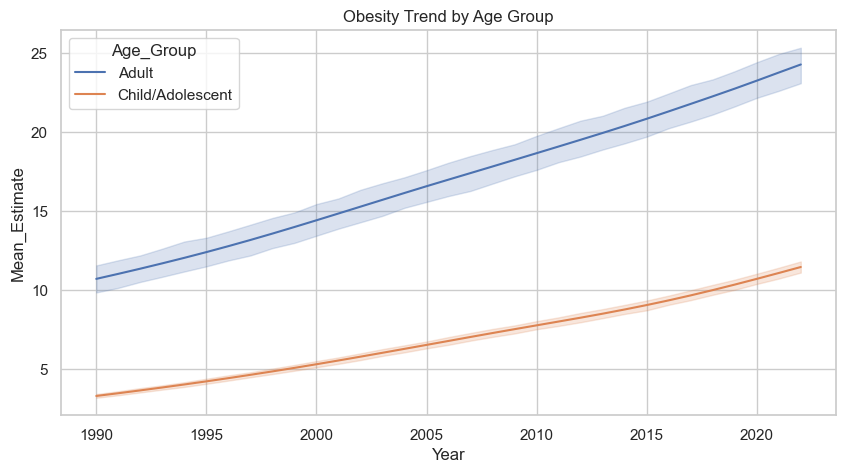

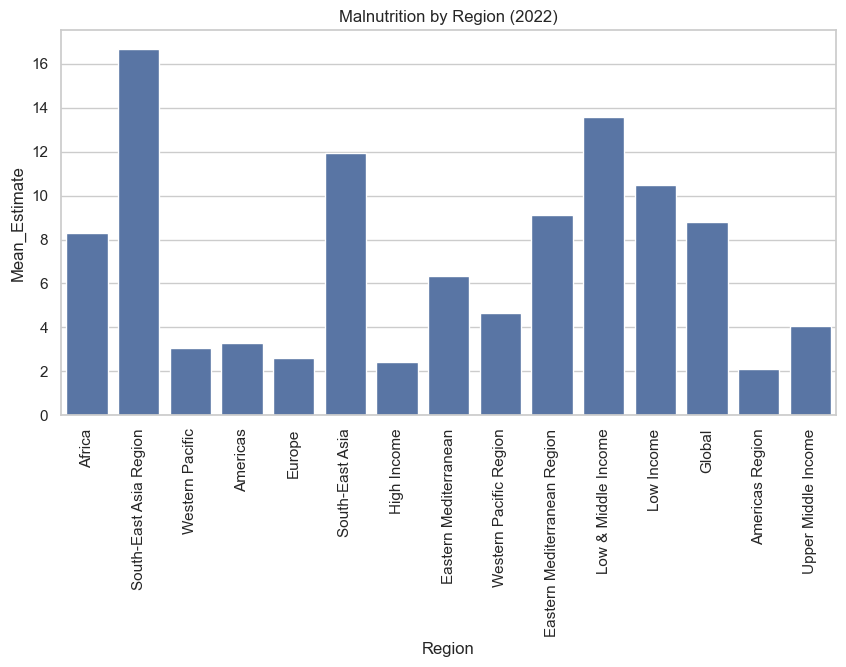

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_obesity, x="Year", y="Mean_Estimate", hue="Age_Group")
plt.title("Obesity Trend by Age Group")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_malnutrition[df_malnutrition['Year'] == 2022], x="Region", y="Mean_Estimate", errorbar=None)
plt.xticks(rotation=90)
plt.title("Malnutrition by Region (2022)")
plt.show()



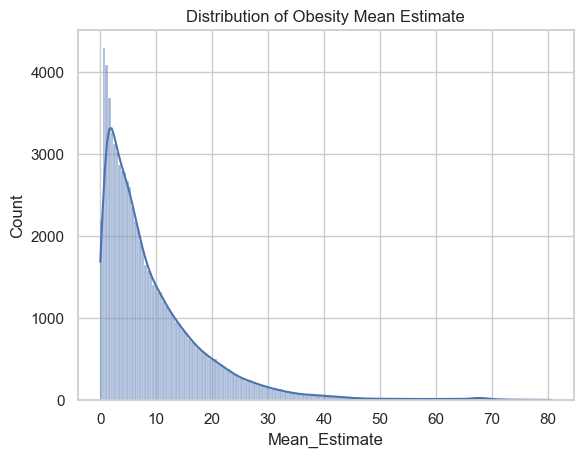

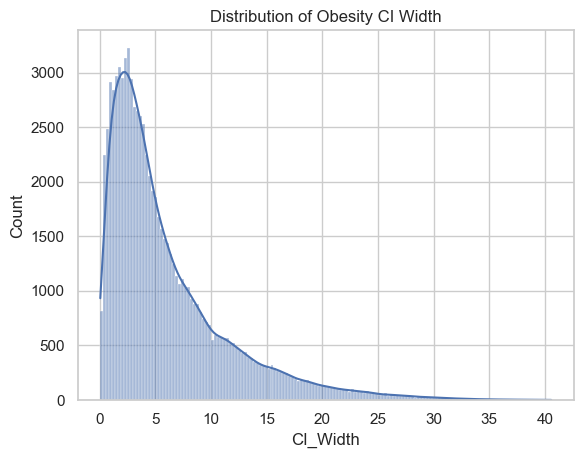

In [11]:
sns.histplot(df_obesity['Mean_Estimate'], kde=True)
plt.title("Distribution of Obesity Mean Estimate")
plt.show()

sns.histplot(df_obesity['CI_Width'], kde=True)
plt.title("Distribution of Obesity CI Width")
plt.show()


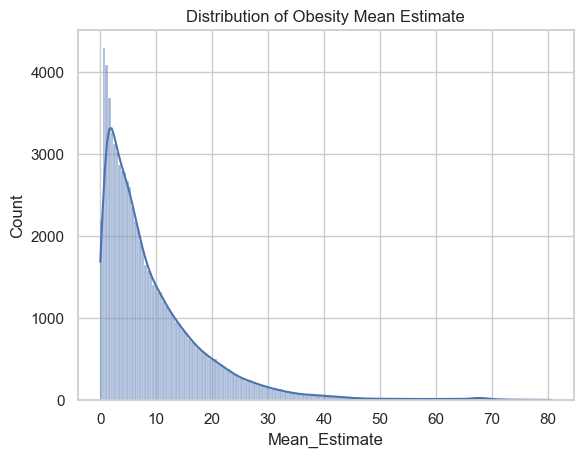

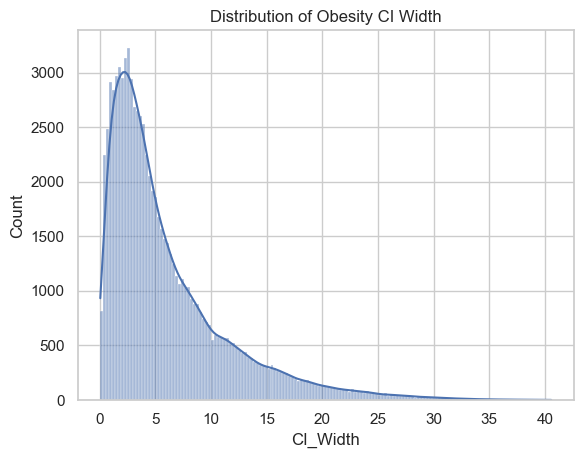

In [12]:
sns.histplot(df_obesity['Mean_Estimate'], kde=True)
plt.title("Distribution of Obesity Mean Estimate")
plt.show()

sns.histplot(df_obesity['CI_Width'], kde=True)
plt.title("Distribution of Obesity CI Width")
plt.show()


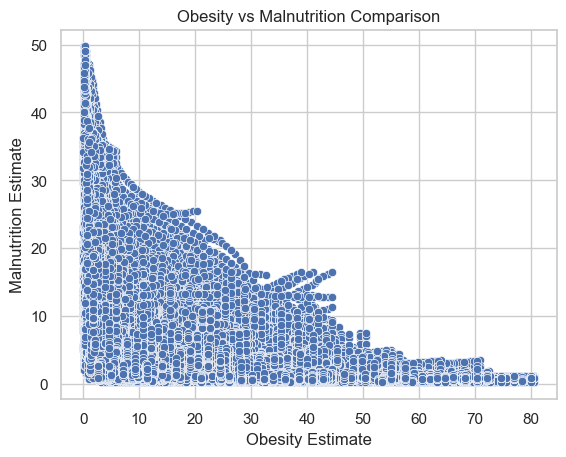

In [13]:
df_merged = pd.merge(
    df_obesity[['Country', 'Year', 'Mean_Estimate']],
    df_malnutrition[['Country', 'Year', 'Mean_Estimate']],
    on=['Country', 'Year'], suffixes=('_Obesity', '_Malnutrition')
)

sns.scatterplot(data=df_merged, x="Mean_Estimate_Obesity", y="Mean_Estimate_Malnutrition")
plt.title("Obesity vs Malnutrition Comparison")
plt.xlabel("Obesity Estimate")
plt.ylabel("Malnutrition Estimate")
plt.show()


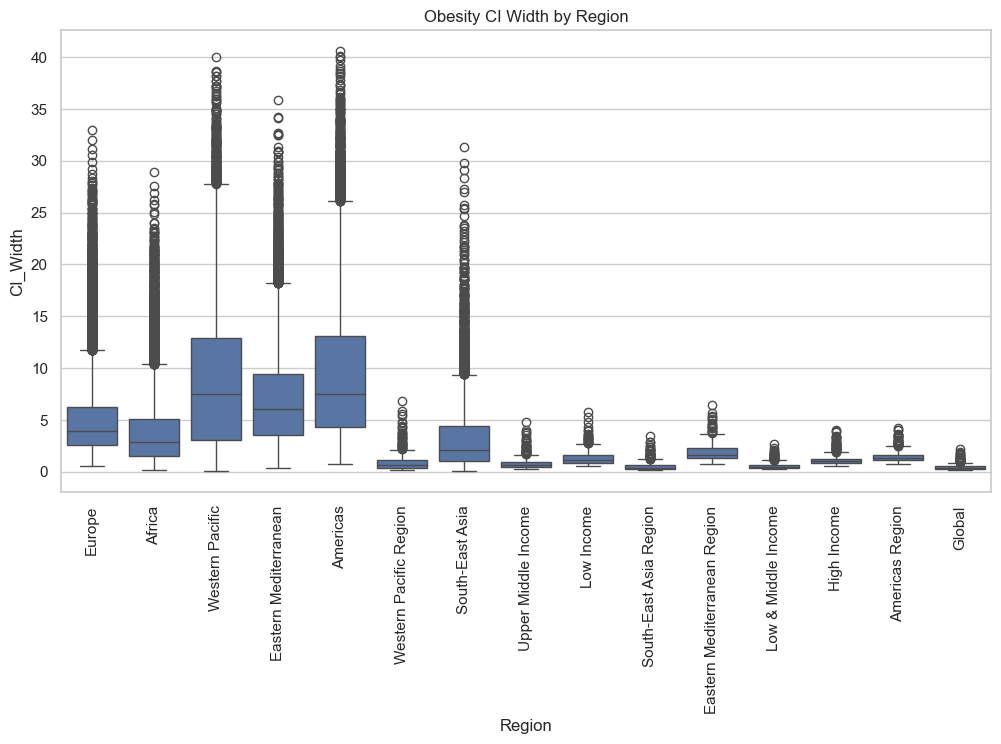

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_obesity, x="Region", y="CI_Width")
plt.xticks(rotation=90)
plt.title("Obesity CI Width by Region")
plt.show()


In [15]:
!pip install mysql-connector-python


In [16]:
import mysql.connector

conn = mysql.connector.connect(
    host="localhost", user="root", password="rakshitha@2906", database="nutrition"
)
cursor = conn.cursor()

# Create tables
cursor.execute("""
CREATE TABLE IF NOT EXISTS obesity (
    Region VARCHAR(255), Gender VARCHAR(20), Year INT,
    LowerBound FLOAT, UpperBound FLOAT, Mean_Estimate FLOAT,
    Country VARCHAR(255), Age_Group VARCHAR(50), CI_Width FLOAT, Obesity_Level VARCHAR(20)
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS malnutrition (
    Region VARCHAR(255), Gender VARCHAR(20), Year INT,
    LowerBound FLOAT, UpperBound FLOAT, Mean_Estimate FLOAT,
    Country VARCHAR(255), Age_Group VARCHAR(50), CI_Width FLOAT, Malnutrition_Level VARCHAR(20)
)
""")

# Insert data
for _, row in df_obesity.iterrows():
    cursor.execute("""
        INSERT INTO obesity VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
    """, tuple(row))

for _, row in df_malnutrition.iterrows():
    cursor.execute("""
        INSERT INTO malnutrition VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
    """, tuple(row))

conn.commit()
conn.close()
